In [191]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
from scipy.stats import pearsonr
from flopy.utils.sfroutputfile import SfrFile

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

import importlib
import treeFuncs
from treeFuncs import trainAndEvaluateModel 
from treeFuncs import metrics


modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput/transientDrawdown"
modws= "D:/mfoutput/transientSeasons"

In [430]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio']#, 'Qout']

# load output from modflow simulations
#outputdf = pd.read_csv('outputs/TransOutputStpSteadyPumpTest.csv') 
outputdf = pd.read_csv('outputs/TransSeasonsOutputStpTest.csv') #output

#load parameters
sampling = np.loadtxt("params/ModflowParams7-750Test12.txt") 
pardf = pd.DataFrame(sampling, columns = col_names)

outputdf = outputdf[['simnum','Qout','reach','Stp']].reset_index() #only keep the cols we need

#Drawdown scenario steps
# numTS = 5 #number of time steps to keep from the end
# stps = 5 - numTS

numTS = 6 #number of time steps to keep from the end
stps = 41 - numTS

StrPer = [i+1 for i in range(stps, stps+numTS)]
print(StrPer)
outputdf = outputdf[outputdf['Stp'] > stps].set_index(['Stp','simnum','reach']) #grab data from the last 5 stress periods and set index to simulation
simindex = outputdf.index.get_level_values('simnum').unique()
timestepidx = outputdf['index'].unique()
pardf = pardf.iloc[simindex]
display(outputdf)
#print(len(timestepidx))
#print(outputdf[outputdf['reach'] == 25])
#print(pardf.reset_index(drop=True))

[36, 37, 38, 39, 40, 41]


index    Qout
Stp simnum reach                
36  1      1        1750   1.000
           2        1751  13.592
           3        1752  25.939
           4        1753  38.338
           5        1754  50.818
...                  ...     ...
41  749    46     860995  45.051
           47     860996  43.080
           48     860997  41.109
           49     860998  39.141
           50     860999  39.114

[126000 rows x 2 columns]

Int64Index([  1,   1,   1,   1,   1,   1,   2,   2,   2,   2,
            ...
            748, 748, 748, 748, 749, 749, 749, 749, 749, 749],
           dtype='int64', name='simnum', length=2520)

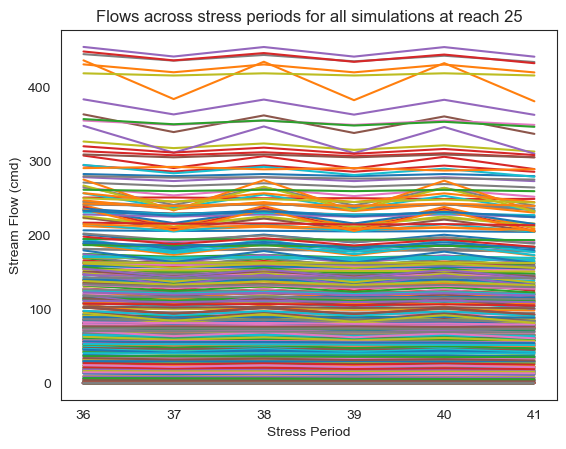

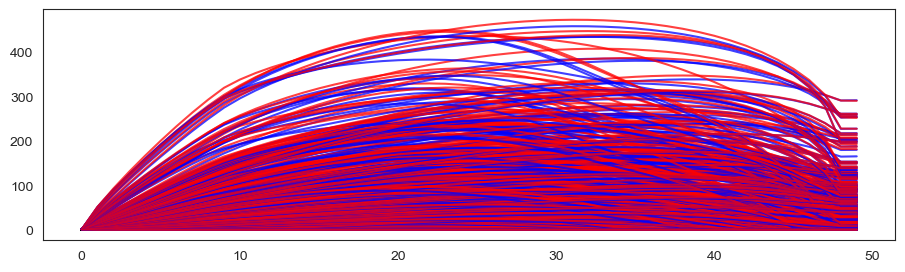

In [422]:
rn = 25
outputs = outputdf.xs(rn,level=2)
display(outputs.index.get_level_values('simnum'))
#outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this

#print(outputs)
#print(outputs.index.get_level_values('simnum').unique())
for i in outputs.index.get_level_values('simnum').unique():#range(int(len(outputs)/10)):
    plt.plot(StrPer,outputs.xs(i,level=1)['Qout'])
plt.xlabel("Stress Period")
plt.ylabel("Stream Flow (cmd)")
plt.title("Flows across stress periods for all simulations at reach " + str(rn))
#plt.ylim([-10,450])
#plt.yscale('log')
#plt.xticks([i for i in range(0, numTS)])
#plt.legend()
plt.show()


#reachQ = outputdf.xs(StrPer[0],level='Stp')
#display(reachQ)

plt.figure(figsize=(11,3))
for i in outputs.index.get_level_values('simnum').unique():#range(int(len(outputs)/10)):
    plt.plot(range(0,50),outputdf.loc[idx[StrPer[-1],i,:]]['Qout'],color='b',alpha=0.75)
    plt.plot(range(0,50),outputdf.loc[idx[StrPer[0],i,:]]['Qout'],color='r',alpha=0.75)

22
23
23
23
23
23
23
(21000, 2)


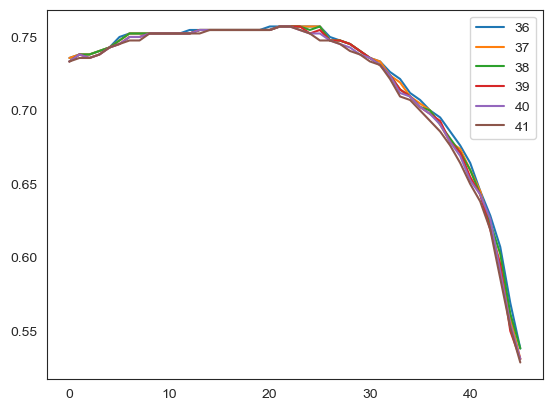

In [390]:
#Getting rid of ensembles with 0 flow
#ReachQdf = pd.read_pickle('outputs/SS_reachQ.pkl')
rn = 25
#ReachQdf  = outputdf.xs(1,level='Stp')
#flowqdf = np.sum(ReachQdf.xs(rn,level='reach')['Qout'] > 0) / len(ReachQdf.xs(rn,level='reach').index)

#display(flowqdf)
for i in StrPer:
    #ReachQdf = pd.DataFrame(np.asarray(outputdf[outputdf['Stp'] == i]['Qout']).reshape((len(simindex),50))) #this is ugly
    ReachQdf = outputdf.xs(i,level='Stp')

    numgrz = [np.sum(ReachQdf.xs(k,level='reach')['Qout'] > 0) / len(ReachQdf.xs(rn,level='reach').index) for k in range(1,51)] 
    print(numgrz.index(max(numgrz[2:])))
    plt.plot(numgrz[2:48], label=i)
   # print(ReachQdf.index)
#ReachQdf = pd.DataFrame(np.asarray(outputdf[outputdf['Stp'] == 5]['Qout']).reshape((len(simindex),50))) #this is ugly
plt.legend()
#numgrz = [len(ReachQdf[i][ReachQdf[i] > 0].index)/len(ReachQdf.index) for i in range(50)] 
#print(numgrz.index(max(numgrz)))

#print(ReachQdf.index)

rn_highest = numgrz.index(max(numgrz[2:])) #find reach with greatest number of wet ensembles 
#ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]
print(rn_highest)
print(ReachQdf.shape)


In [431]:
#New way of pulling out simulations that are dry using multi-level index

print(outputdf.index.get_level_values('simnum'))

HighRn = outputdf.xs(rn_highest,level='reach') #get a slice of the highest reach Qout
grtzSims = HighRn[HighRn['Qout'] > 0].index.get_level_values('simnum').unique().values

idx = pd.IndexSlice #makes slicing multilevel indexs easier
RevisedOutputdf = outputdf.loc[idx[:,grtzSims,:] , :].drop(columns='index')
#display(RevisedOutputdf)
#display(outputdf)
pardf = pardf.loc[grtzSims]


Int64Index([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            ...
            749, 749, 749, 749, 749, 749, 749, 749, 749, 749],
           dtype='int64', name='simnum', length=126000)


# Decision Tree Code
Most of below is from:https://www.datacamp.com/community/tutorials/decision-tree-classification-python

In [392]:
#Testing using the multilevel index to get Qout for each stress period
outputs = RevisedOutputdf.loc[idx[:,:,25]].unstack(level='Stp')
display(outputs)

Qout                                             
Stp                36       37       38       39       40       41
simnum reach                                                      
1      25     200.570  189.880  200.340  189.660  200.120  189.450
2      25      47.774   47.488   47.272   46.991   46.774   46.497
3      25      46.872   46.198   46.579   45.916   46.291   45.635
6      25      79.207   78.134   78.665   77.590   78.136   77.059
7      25     232.270  228.910  230.660  227.390  229.070  225.890
...               ...      ...      ...      ...      ...      ...
742    25     453.840  440.860  453.720  440.750  453.620  440.650
743    25      33.501   31.601   32.796   30.922   32.102   30.259
744    25      24.059   21.737   23.817   21.516   23.578   21.298
748    25     418.180  415.220  418.200  415.240  418.220  415.260
749    25      40.174   39.760   40.156   39.742   40.138   39.725

[318 rows x 6 columns]

Shape of Input Samples: (318, 7)
Shape of Output Targets: (318, 6)
Plot showing just simulaions with Q > 0


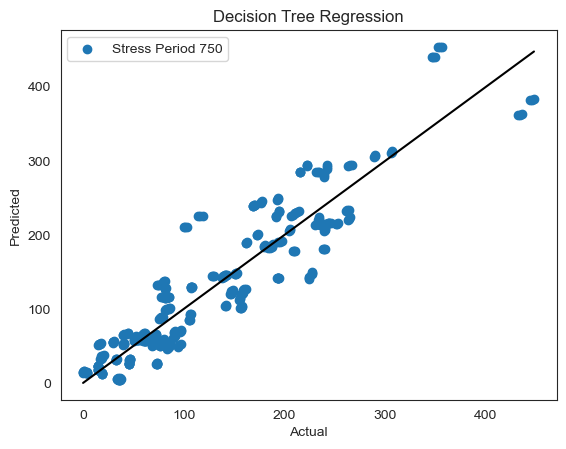

bias    -1.616180
rmse    37.334206
r        0.923532
nse      0.834963
kge      0.904155
dtype: float64

In [423]:
# Split dataset into training set and test set, default here is 30% test
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel
rn  = 25 #reach number
#old way
#outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this
#New way
outputs = RevisedOutputdf.loc[idx[:,:,rn]].unstack(level='Stp')

pars = None
n=1

impdf, metricsdf, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, pardf, outputs, pars, 0.2, n)

print('Plot showing just simulaions with Q > 0')
# Plot the results
plt.figure()

#print(y_test,y_pred.flatten())
#for i in range(1,numTS+1):
plt.scatter(y_test, y_pred, label = str("Stress Period " + str(1+i)))
outmax = np.max(y_test)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

display(metricsdf)


K                 0.307360
Low_K_ratio       0.012651
Sy                0.007262
Rech              0.207161
ET_valley         0.006084
ET_rip_ratio      0.011402
Stream_K_ratio    0.448079
Name: 0, dtype: float64

<Axes: >

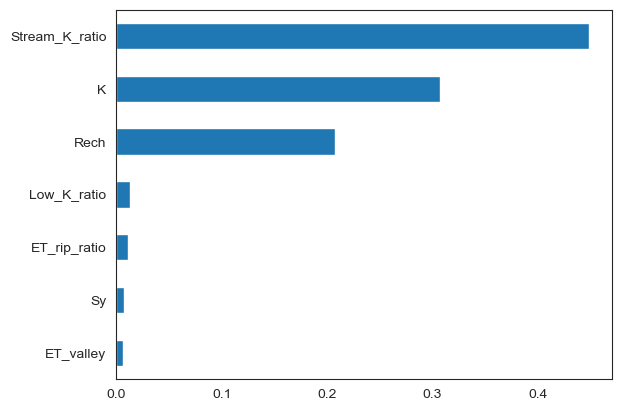

In [424]:
#evalTree(clf)
display(impdf[0])
impdf.loc[:,0].sort_values().plot(kind='barh')

In [236]:
# #feature importance
# importance = clf.feature_importances_
# print(importance)
# imp_names = clf.feature_names_in_
# print(imp_names)
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# # plt.bar([x for x in range(len(importance))], importance)
# # plt.show()

# feat_importances = pd.Series(clf.feature_importances_, index=clf.feature_names_in_)
# feat_importances.nlargest(20).plot(kind='barh')

Reach 1 NSE:  nan
Reach 2 NSE:  0.8439019395768899
Reach 3 NSE:  0.7942909085079793
Reach 4 NSE:  0.8322360867122691
Reach 5 NSE:  0.8706608394813742
Reach 6 NSE:  0.8851407034739618
Reach 7 NSE:  0.8821799734244343
Reach 8 NSE:  0.8795731908164682
Reach 9 NSE:  0.8761553976425285
Reach 10 NSE:  0.8174163270142899
Reach 11 NSE:  0.8317347515520043
Reach 12 NSE:  0.8930191095824195
Reach 13 NSE:  0.8770772346375169
Reach 14 NSE:  0.8741486958319388
Reach 15 NSE:  0.8717590203926915
Reach 16 NSE:  0.8892939608480654
Reach 17 NSE:  0.8916471511054146
Reach 18 NSE:  0.8775680318748764
Reach 19 NSE:  0.8640998464123669
Reach 20 NSE:  0.8799424704313245
Reach 21 NSE:  0.8820603312742261
Reach 22 NSE:  0.8847411480081955
Reach 23 NSE:  0.9011633155738611
Reach 24 NSE:  0.8804734012421587
Reach 25 NSE:  0.8645773158500196
Reach 26 NSE:  0.8774575484208653
Reach 27 NSE:  0.912052764159671
Reach 28 NSE:  0.8948899055272923
Reach 29 NSE:  0.9091893856628902
Reach 30 NSE:  0.907342893382526
Reach 

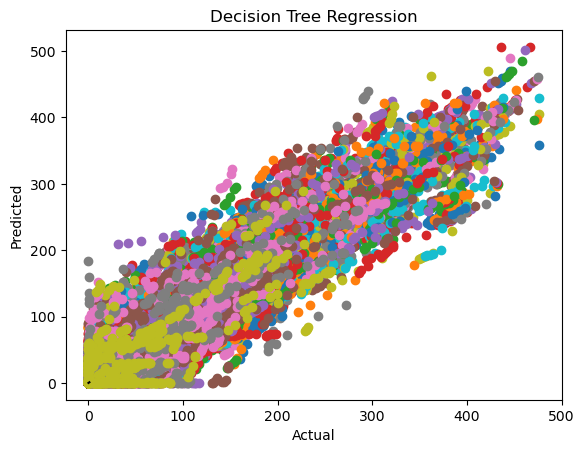

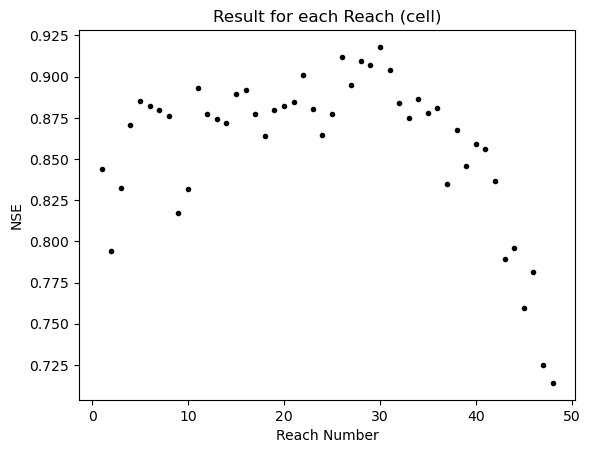

Feature: 0, Score: 0.38621
Feature: 1, Score: 0.11580
Feature: 2, Score: 0.00480
Feature: 3, Score: 0.34317
Feature: 4, Score: 0.00728
Feature: 5, Score: 0.00829
Feature: 6, Score: 0.13445


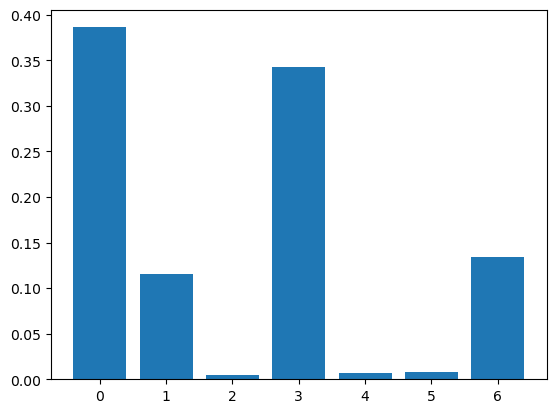

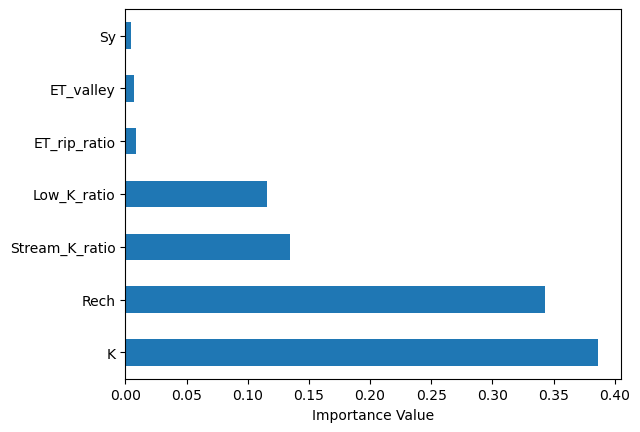

In [8]:
#try to predict Qout with parameters at every reach
reachnum = 50
Reach_importance = []
nse_list = []
simnum = []

for i in range(1,reachnum):
    
    Y3 = np.asarray(outputdf[outputdf['reach'] == i]['Qout']).reshape((len(simindex),numTS))#[:,1] #probably a better way to do this

    X3 = pardf
    
   # numgrz = np.where(Y3 > 0) 
   # print('Number of simulations > 0 : ' + str(numgrz))
    
    # Split dataset into training set and test set, default here is 30% test
    X_train, X_test, y_train, y_test = train_test_split(X3, Y3, test_size=0.3, random_state=0)

    # Create Decision Tree classifer object
    reachTree = DecisionTreeRegressor(
        #random_state = 0
         #max_depth = 9
    )

    # Train Decision Tree Classifer
    reachTree = reachTree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = reachTree.predict(X_test)

    #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#     print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#     print("NSE: ", NSE(y_test, y_pred))
#     print("Tree Depth: ", reachTree.get_depth())
    #print("Reach "+str(i)+" RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
    print("Reach "+str(i) + " NSE: ", NSE(y_pred, y_test))
    nse_list.append(NSE(y_pred, y_test))
   # simnum.append(numgrz)
    # Plot the results
    #plt.figure()
    label = "Reach " + str(i)
    plt.scatter(y_test, y_pred, label = label)  

   #plt.legend()


    #feature importance
    importance = reachTree.feature_importances_
    Reach_importance.append(importance)

#outmax = np.max(ReachQ)
outmax = 1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
#plt.legend()
plt.show()

plt.plot(nse_list, 'k.')

plt.xlabel("Reach Number")
plt.ylabel("NSE")
plt.title("Result for each Reach (cell)")
plt.show()

#feature importance
importance = reachTree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

feat_importances = pd.Series(reachTree.feature_importances_, index=reachTree.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh',)
plt.xlabel('Importance Value')
#plt.ylabel('ylabel')
plt.show()
# plt.plot(simnum)

# plt.xlabel("Reach Number")
# plt.ylabel("Number of Simulations with Q > 0")
# plt.title("Number of non-dry simulations for each Reach (cell)")
# plt.show()

## Now for the Wells

In [403]:
#all_well_loc = np.array(np.meshgrid(np.arange(50),np.arange(50))).T.reshape(-1,2)
#print(all_well_loc)

#load in Ibound and find active cells in model - then put it into a list of well locations
ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T

#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_head = np.empty((all_well_loc.shape[0], len(grtzSims),numTS))



In [4]:
# #Cell block for test head object out put - can ignore 

# modelname = "ScenarioSfr750Seasons_"+str(simindex[0])
# headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
# head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
# print(head.shape)
# print(head[::30,21,32][-6:])
# headtimes = np.array(headobj.get_times())
# print(headtimes)

# print(headtimes[::30])
# print(len(headtimes[::30]))

# headts = headobj.get_ts([(0,21,32)])
# #headts[10:,0] = (headts[10:,0] / 6) * 50  *2
# print(headts[::30][-numTS:].astype('int'))
# print(headobj.get_ts([(0,21,32)])[::30,1][-numTS:].astype('int'))


# print(len(headts))
# headstp = np.divmod(np.arange(len(headts)-10),30*2)[0]+1

# plt.plot(headts[::30,1])
# plt.show()
# plt.plot(headts[:,1])

In [405]:
#Get Head data for All active wells
#import seaborn as sns
sns.set_style("white")
modws= "D:/mfoutput/transientSeasons"
#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_error_sim = []
#well_error_num = []

for j, i in enumerate(grtzSims):
    modelname = "ScenarioSfr750SeasonsTest_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#     for k in range(all_well_loc.shape[0]):
#         well_head[k][j][:] = headobj.get_ts([(0,int(all_well_loc[k][0]),int(all_well_loc[k][1]))])[::30,1][-numTS:] #complicated way of getting all the heads (numTS) by sampling every 30 of the head ts foreach well
#         if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
#                 well_error_sim.append(i)              
                
    head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
    for k in range(all_well_loc.shape[0]): #grabbing the last n Stress periods (-numTS)
            well_head[k][j][:] = head[::30,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would 
           # well_head[k][j][1] = head[-1][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would  be 60
            if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
                well_error_sim.append(i)
print("Done")          

Done


In [406]:
## Delete out simulations where well head is twice the average
print(well_head.shape)
#print(well_head.transpose(1,0,2).reshape(len(simindex),well_head.shape[0]*numTS))
RevisedPardf = pardf.loc[~pardf.index.isin(np.unique(well_error_sim))]
#new_zone.head
well_head_df = pd.DataFrame(well_head.transpose(1,0,2).reshape(len(grtzSims),well_head.shape[0]*numTS),index=grtzSims)#, index = pardf.index) #put the wwells into an unput that has each stress period so now input os 4024 long
display(well_head_df)
print(len(well_head_df.index))

well_head_df.to_pickle('outputs/heads/Well_head_seasons.pkl')
RevisedPardf.to_pickle('params/Seasons_pardf.pkl')   
print(len(well_head_df.index))
print(RevisedPardf)




(2012, 318, 6)


,0,1,2,3,4,5,6,7,8,9,...,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071
1,100.947212,100.943222,100.939056,100.935188,100.931114,100.927330,100.701523,100.697456,100.693352,100.689392,...,94.918785,94.913712,94.908867,94.903961,94.603149,94.597885,94.592873,94.587761,94.582893,94.577965
2,99.750465,99.712372,99.674309,99.636322,99.598457,99.560699,99.503525,99.465179,99.426880,99.388687,...,94.133789,94.105339,94.076935,94.048485,93.854149,93.825554,93.797020,93.768486,93.739990,93.711479
3,100.362366,100.353127,100.343575,100.333717,100.323479,100.313087,100.132065,100.122528,100.112663,100.102463,...,94.597198,94.587219,94.577087,94.566917,94.284721,94.274788,94.264763,94.254532,94.244232,94.233887
6,97.486771,97.465065,97.439606,97.418259,97.393150,97.372131,97.236900,97.219040,97.190025,97.172516,...,93.040985,93.028786,93.017067,93.004745,92.797356,92.785591,92.774338,92.762405,92.751015,92.738930
7,100.579979,100.560577,100.541008,100.521278,100.501411,100.481422,100.332970,100.313255,100.293381,100.273338,...,94.676277,94.663857,94.651382,94.638878,94.366570,94.354050,94.341507,94.328903,94.316261,94.303574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,107.361809,107.360550,107.358917,107.357780,107.356262,107.355202,107.068184,107.066818,107.065308,107.064056,...,99.819481,99.817291,99.814789,99.812767,99.425453,99.423111,99.420387,99.418221,99.415680,99.413704
743,93.388260,93.371178,93.332642,93.316154,93.278214,93.262276,93.172318,93.150993,93.116806,93.096085,...,89.623306,89.603996,89.587303,89.567978,89.424553,89.405449,89.389069,89.369919,89.353493,89.334305
744,93.971336,93.966354,93.961098,93.955833,93.950363,93.945038,93.774445,93.769455,93.763885,93.758705,...,89.369110,89.364891,89.361862,89.357513,89.107132,89.102905,89.099937,89.095573,89.092537,89.088066
748,103.653870,103.654572,103.655258,103.655922,103.656525,103.657120,103.383713,103.384415,103.385078,103.385727,...,97.242516,97.242462,97.242393,97.242355,96.916084,96.916016,96.915894,96.915840,96.915733,96.915688


318
318
            K  Low_K_ratio        Sy      Rech  ET_valley  ET_rip_ratio  \
1    0.252596     0.000074  0.058034  0.000203   0.000009      3.185117   
2    0.425213     0.761486  0.108251  0.000293   0.000002      2.180845   
3    0.258080     0.028534  0.218521  0.000174   0.000007      3.005435   
6    0.347367     0.000020  0.239157  0.000223   0.000001      3.860679   
7    0.386306     0.091339  0.150186  0.000294   0.000003      2.112911   
..        ...          ...       ...       ...        ...           ...   
742  0.269037     0.000256  0.051848  0.000297   0.000007      2.705785   
743  0.418067     0.000026  0.146381  0.000224   0.000001      3.669379   
744  0.483446     0.000387  0.400454  0.000248   0.000002      2.479872   
748  0.286648     0.000012  0.094791  0.000281   0.000001      2.771297   
749  0.263331     0.000028  0.123302  0.000162   0.000006      1.388855   

     Stream_K_ratio  
1          0.011219  
2          0.001214  
3          0.001196  
6  

In [445]:
#Only necessary if pulling well_head_df from pkl or csv

#well_head_df = pd.read_pickle('outputs/heads/Well_head_drawdown.pkl')
well_head_df = pd.read_pickle('outputs/heads/Well_head_seasons.pkl')

#new_zone = pd.read_pickle('params/Drawdown_pardf.pkl')
new_zone = pd.read_pickle('params/Seasons_pardf.pkl')

well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_heads_loc = np.arange(all_well_loc.shape[0]*numTS).reshape((int(all_well_loc.shape[0]),numTS)) #splits the well head_df into subsets aplicable to the location (so we ahve numTS outputs)

wellnums_arr = np.arange(well_head.shape[0])
stps_arr = StrPer
column_idx = pd.MultiIndex.from_product([wellnums_arr.astype('str'), stps_arr],
                           names=['wellnum', 'Stp'])
well_head_df.columns = column_idx

display(well_head_df)

wellnum           0                                                  \
Stp              36          37          38          39          40   
1        100.947212  100.943222  100.939056  100.935188  100.931114   
2         99.750465   99.712372   99.674309   99.636322   99.598457   
3        100.362366  100.353127  100.343575  100.333717  100.323479   
6         97.486771   97.465065   97.439606   97.418259   97.393150   
7        100.579979  100.560577  100.541008  100.521278  100.501411   
..              ...         ...         ...         ...         ...   
742      107.361809  107.360550  107.358917  107.357780  107.356262   
743       93.388260   93.371178   93.332642   93.316154   93.278214   
744       93.971336   93.966354   93.961098   93.955833   93.950363   
748      103.653870  103.654572  103.655258  103.655922  103.656525   
749       98.082314   98.081413   98.080460   98.079529   98.078537   

wellnum                       1                                      ...  \
Stp              41          36          37          38          39  ...   
1        100.927330  100.701523  100.697456  100.693352  100.689392  ...   
2         99.560699   99.503525   99.465179   99.426880   99.388687  ...   
3        100.313087  100.132065  100.122528  100.112663  100.102463  ...   
6         97.372131   97.236900   97.219040   97.190025   97.172516  ...   
7        100.481422  100.332970  100.313255  100.293381  100.273338  ...   
..              ...         ...         ...         ...         ...  ...   
742      107.355202  107.068184  107.066818  107.065308  107.064056  ...   
743       93.262276   93.172318   93.150993   93.116806   93.096085  ...   
744       93.945038   93.774445   93.769455   93.763885   93.758705  ...   
748      103.657120  103.383713  103.384415  103.385078  103.385727  ...   
749       98.077621   97.869987   97.869080   97.868118   97.867180  ...   

wellnum       2010                                        2011             \
Stp             38         39         40         41         36         37   
1        94.918785  94.913712  94.908867  94.903961  94.603149  94.597885   
2        94.133789  94.105339  94.076935  94.048485  93.854149  93.825554   
3        94.597198  94.587219  94.577087  94.566917  94.284721  94.274788   
6        93.040985  93.028786  93.017067  93.004745  92.797356  92.785591   
7        94.676277  94.663857  94.651382  94.638878  94.366570  94.354050   
..             ...        ...        ...        ...        ...        ...   
742      99.819481  99.817291  99.814789  99.812767  99.425453  99.423111   
743      89.623306  89.603996  89.587303  89.567978  89.424553  89.405449   
744      89.369110  89.364891  89.361862  89.357513  89.107132  89.102905   
748      97.242516  97.242462  97.242393  97.242355  96.916084  96.916016   
749      93.123878  93.122223  93.120552  93.118896  92.846779  92.845070   

wellnum                                              
Stp             38         39         40         41  
1        94.592873  94.587761  94.582893  94.577965  
2        93.797020  93.768486  93.739990  93.711479  
3        94.264763  94.254532  94.244232  94.233887  
6        92.774338  92.762405  92.751015  92.738930  
7        94.341507  94.328903  94.316261  94.303574  
..             ...        ...        ...        ...  
742      99.420387  99.418221  99.415680  99.413704  
743      89.389069  89.369919  89.353493  89.334305  
744      89.099937  89.095573  89.092537  89.088066  
748      96.915894  96.915840  96.915733  96.915688  
749      92.843369  92.841682  92.839981  92.838303  

[318 rows x 12072 columns]

In [409]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import wellmesh_correlation


#only get the heads for a certain TS - this is a little convoluted but it's what I had already
test_head = well_head_df.to_numpy().reshape((len(grtzSims),well_head.shape[0],numTS))
Stp_head_df = pd.DataFrame(test_head[:,:,-1])

with pd.option_context('display.max_rows', 8, 'display.max_columns', 8):
    display(Stp_head_df)


wellmesh_corr = wellmesh_correlation(all_well_loc,Stp_head_df)

,0,1,2,3,...,2008,2009,2010,2011
0,100.927330,100.681511,100.274384,99.772087,...,95.849487,95.350571,94.903961,94.577965
1,99.560699,99.312645,98.903267,98.399734,...,95.018173,94.507835,94.048485,93.711479
2,100.313087,100.081284,99.698112,99.226105,...,95.526146,95.021187,94.566917,94.233887
3,97.372131,97.126656,96.719322,96.208710,...,93.759735,93.364182,93.004745,92.738930
...,...,...,...,...,...,...,...,...,...
314,93.262276,93.042320,92.672127,92.206238,...,90.232361,89.884148,89.567978,89.334305
315,93.945038,93.747581,93.421944,93.023666,...,90.132584,89.724777,89.357513,89.088066
316,103.657120,103.386909,102.937805,102.381058,...,98.195557,97.691544,97.242355,96.915688
317,98.077621,97.865242,97.515099,97.085770,...,93.925766,93.501251,93.118896,92.838303


[[4.53372723 4.53304706 4.53370194 4.53318395 4.53401232 4.53364288]
 [4.50758752 4.50781613 4.50761659 4.50801365 4.50798081 4.50853454]
 [4.4627622  4.46624715 4.46287405 4.46655097 4.46332227 4.46717942]
 ...
 [3.71979708 3.71889281 3.71854344 3.71784357 3.71766156 3.71715547]
 [3.6585708  3.65752507 3.65742336 3.65658964 3.6566449  3.65601102]
 [3.61439042 3.61298919 3.61333121 3.61215532 3.61263844 3.61167139]]


C:\Users\davem\AppData\Local\Temp\ipykernel_18204\95687791.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


<Figure size 800x600 with 0 Axes>

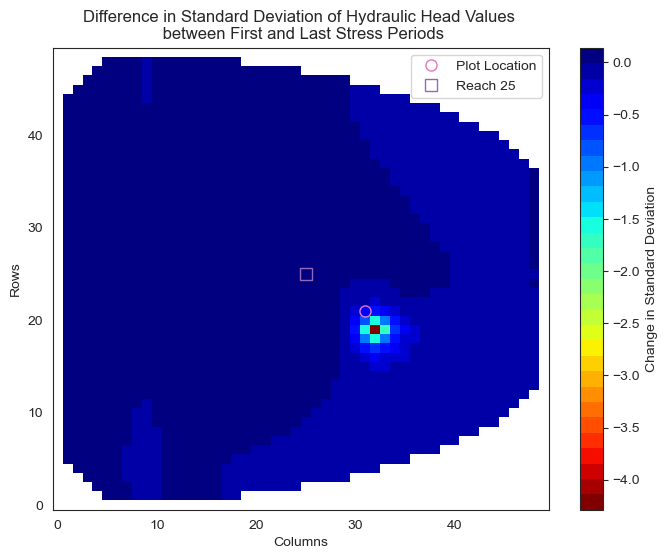

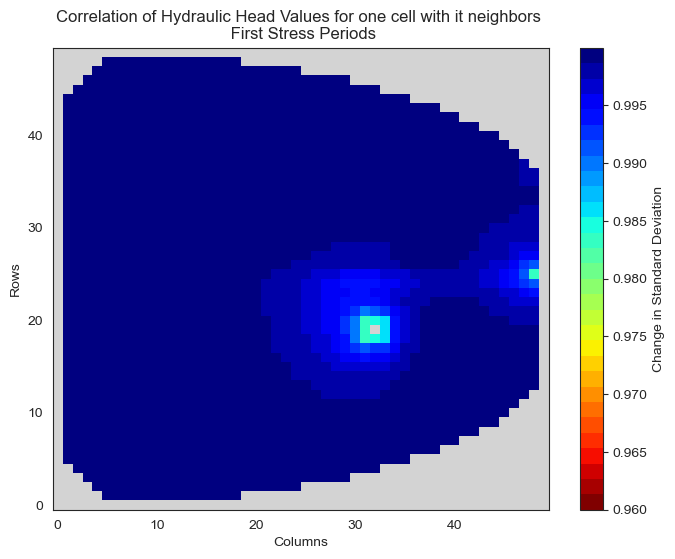

In [410]:
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm
wn = 844

kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

test_head = well_head_df.to_numpy().reshape((len(grtzSims),well_head.shape[0],numTS))
#print(test_head)
# well_head_var = test.var(axis=(0,1))
# print(well_head_var.shape)
# #print(well_head_var)
well_head_var = np.empty((well_head.shape[0],numTS))

for i in range(well_head.shape[0]):
    for k in range(numTS):
        well_head_var[i][k] = np.std(test_head[:,i,k])
        
print(well_head_var)
wellmesh = np.ndarray((numTS,50,50))
wellmesh[:][:][:] = -1e30

for i in range(all_well_loc.shape[0]):
    wellmesh[:,int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_var[i]

#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgrey")


plt.figure(figsize=(8,6))

# for i in range(numTS):
#     plt.figure(figsize=(8,6))
#     plt.pcolormesh(KK,GG,wellmesh[i], vmax = 6,cmap = cmap2, vmin = 0,shading='nearest')
#     plt.colorbar(label = 'Std')
#     plt.xlabel('Columns')
#     plt.ylabel('Rows')
#     plt.title('Standard Deviation of the head values across the simulations \n Stress Period: ' +str(i +1))
#     plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
wm_dif = wellmesh[0]-wellmesh[-1]
wm_dif = np.ma.masked_array(wm_dif, wellmesh[0] < 0)
#plt.imshow(wellmesh, cmap='RdBu')
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wm_dif, cmap = cmap2, shading='nearest')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="tab:pink", mfc='none', linestyle = "None", label="Plot Location")
#plt.plot(range(1,49),river, color="lightblue",label='River')
plt.plot(25,25, marker="s", markersize=8, color="tab:purple", mfc='none', linestyle = "None", label="Reach 25")

#plt.plot(31, 20, marker="x", markersize=8, color="White", linestyle = "None", label="Obs")
plt.colorbar(label = 'Change in Standard Deviation')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Difference in Standard Deviation of Hydraulic Head Values \n between First and Last Stress Periods')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_corr, cmap = cmap2,vmin = 0.96, shading='nearest')
#plt.plot(31, 20, marker="x", markersize=8, color="White", linestyle = "None", label="Obs")
plt.colorbar(label = 'Change in Standard Deviation')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Correlation of Hydraulic Head Values for one cell with it neighbors \n First Stress Periods')
plt.show()


2012


C:\Users\davem\AppData\Local\Temp\ipykernel_18216\462508883.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


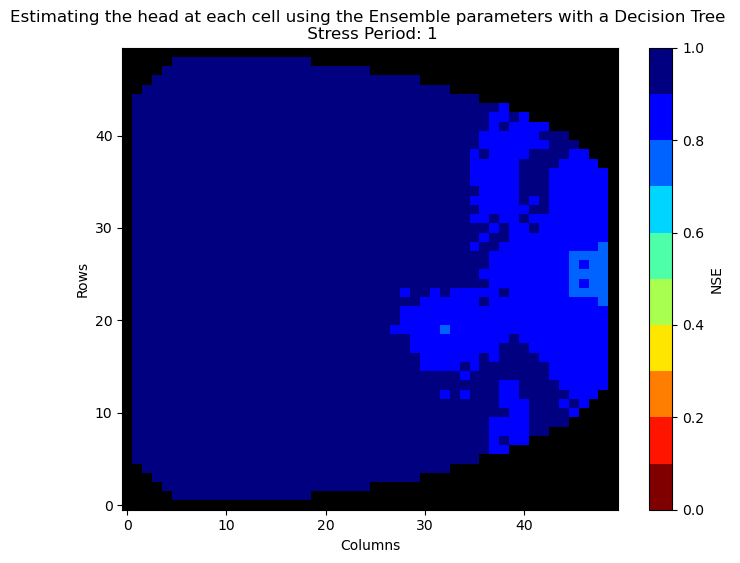

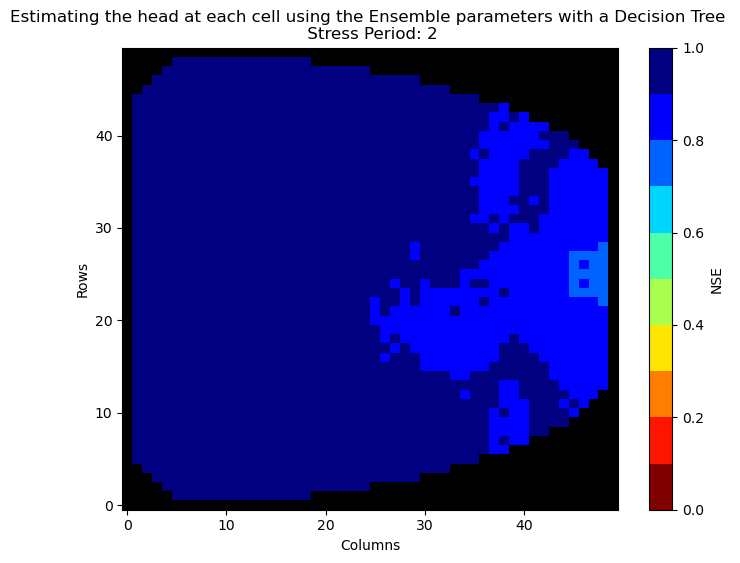

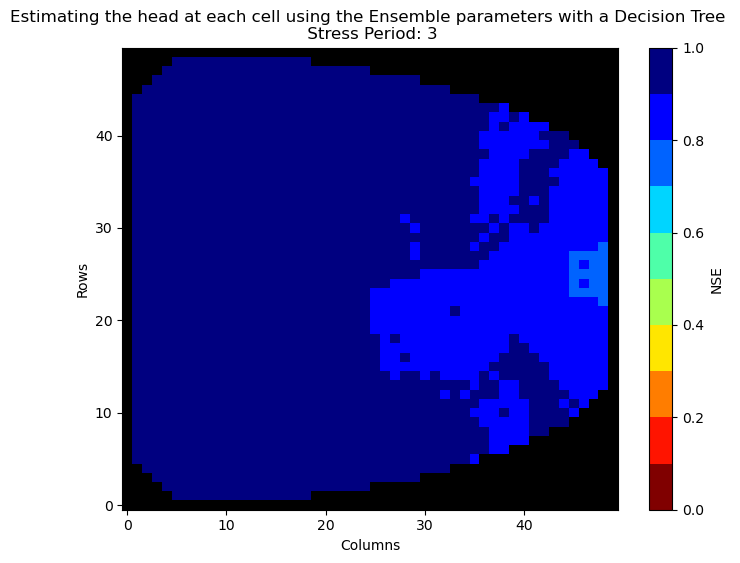

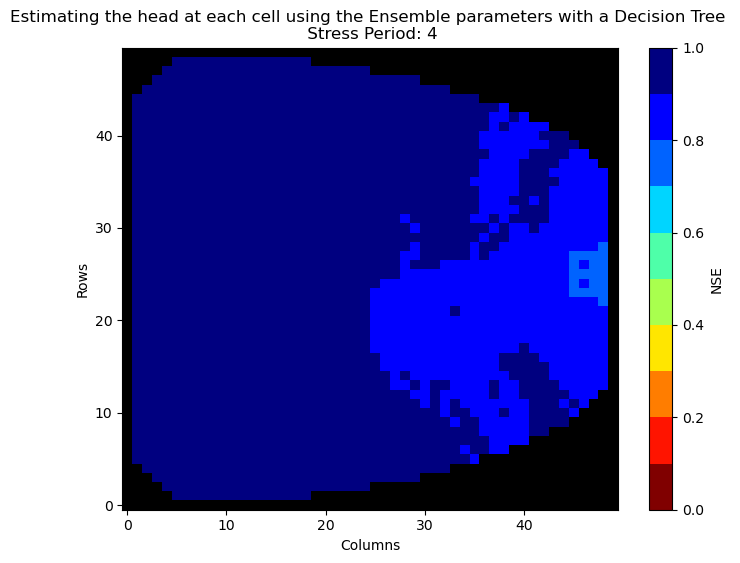

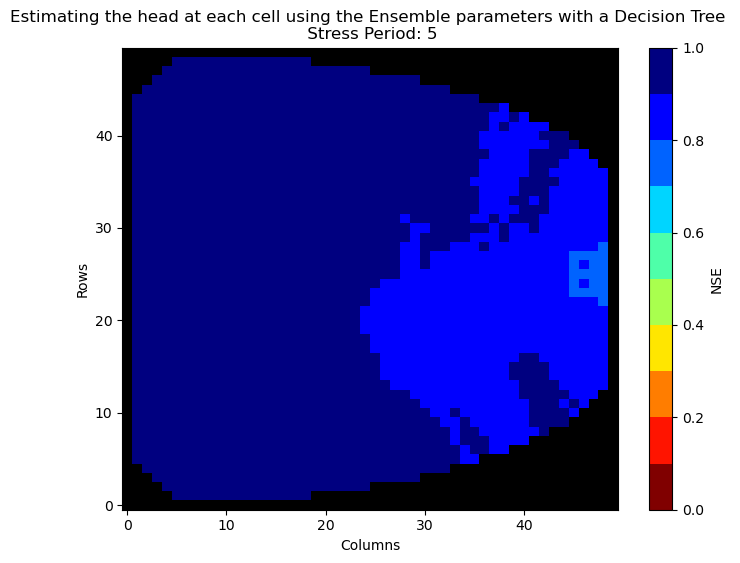

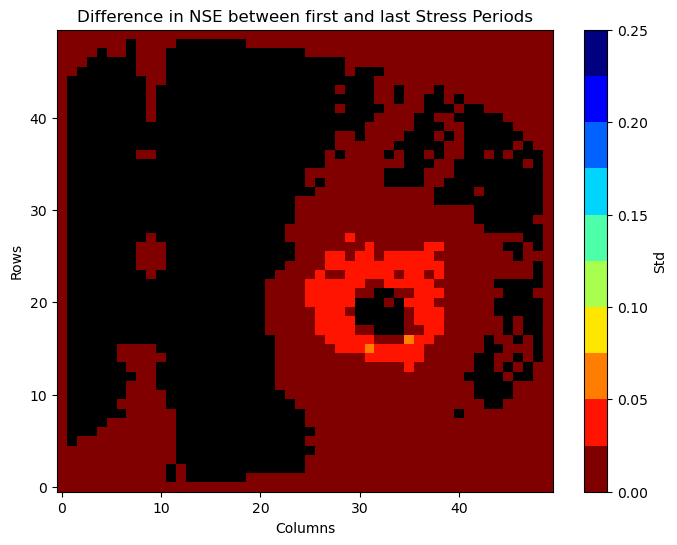

In [19]:


nse_list_remove = nse_list#[-50 if (np.any(np.isinf(x)) or np.any(np.isnan(x))) else x for x in nse_list] #np.any only nessesay if pasing NSE for each stress period individually 
#s = np.isnan(nse_list_remove)
nse_list_remove = np.reshape(nse_list_remove,(len(nse_list_remove),numTS))

print(len(nse_list_remove))

wellmesh = np.ndarray((numTS,50,50))
wellmesh[:] = -1e30

for k in range(numTS):
    for i in range(all_well_loc.shape[0]):
        wellmesh[k][int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = nse_list_remove[i][k]
        
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=10)
cmap2.set_under("k")

#plt.figure(figsize=(8,6))
for i in range(numTS):
    plt.figure(figsize=(8,6))
    plt.pcolormesh(KK,GG,wellmesh[i], vmax = 1,cmap = cmap2, vmin = 0,shading='nearest')  
    plt.colorbar(label = 'NSE')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Estimating the head at each cell using the Ensemble parameters with a Decision Tree \n Stress Period: ' +str(i +1))
    #plt.pcolormesh(KK,GG,wellmesh, vmax = 1,cmap = cmap2, vmin = -1,shading='nearest')
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh[0] - wellmesh[-1], vmax = 0.25,cmap = cmap2, vmin = 0.,shading='nearest')
plt.colorbar(label = 'Std')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Difference in NSE between first and last Stress Periods')
plt.show() 

## Using Wells to predict stream Flow

In [446]:
# Since we changed the number of wells - use this for flow only outputs
#well_df = pd.DataFrame(new_well_head.transpose(), index = new_zone.index)

river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

CHBound_loc = np.where(all_well_loc[:,1] >47) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)

AllWells = np.arange(all_well_loc.shape[0])

noRivWells = [str(i) for i in AllWells if i not in drop_locs[0]]
print(len(noRivWells))

well_head_noRiv = well_head_df.loc[:,idx[noRivWells,:]]  

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])
#display(well_loc_df)
#print(well_head_noRiv.shape)
#display(well_head_noRiv)

1941


,0,1
0,1,5
1,1,6
2,1,7
3,1,8
4,1,9
...,...,...
2007,48,14
2008,48,15
2009,48,16
2010,48,17


wellnum           0                                                  \
Stp              36          37          38          39          40   
1        100.947212  100.943222  100.939056  100.935188  100.931114   
2         99.750465   99.712372   99.674309   99.636322   99.598457   
3        100.362366  100.353127  100.343575  100.333717  100.323479   
6         97.486771   97.465065   97.439606   97.418259   97.393150   
7        100.579979  100.560577  100.541008  100.521278  100.501411   
..              ...         ...         ...         ...         ...   
742      107.361809  107.360550  107.358917  107.357780  107.356262   
743       93.388260   93.371178   93.332642   93.316154   93.278214   
744       93.971336   93.966354   93.961098   93.955833   93.950363   
748      103.653870  103.654572  103.655258  103.655922  103.656525   
749       98.082314   98.081413   98.080460   98.079529   98.078537   

wellnum                       1                                      ...  \
Stp              41          36          37          38          39  ...   
1        100.927330  100.701523  100.697456  100.693352  100.689392  ...   
2         99.560699   99.503525   99.465179   99.426880   99.388687  ...   
3        100.313087  100.132065  100.122528  100.112663  100.102463  ...   
6         97.372131   97.236900   97.219040   97.190025   97.172516  ...   
7        100.481422  100.332970  100.313255  100.293381  100.273338  ...   
..              ...         ...         ...         ...         ...  ...   
742      107.355202  107.068184  107.066818  107.065308  107.064056  ...   
743       93.262276   93.172318   93.150993   93.116806   93.096085  ...   
744       93.945038   93.774445   93.769455   93.763885   93.758705  ...   
748      103.657120  103.383713  103.384415  103.385078  103.385727  ...   
749       98.077621   97.869987   97.869080   97.868118   97.867180  ...   

wellnum       2010                                        2011             \
Stp             38         39         40         41         36         37   
1        94.918785  94.913712  94.908867  94.903961  94.603149  94.597885   
2        94.133789  94.105339  94.076935  94.048485  93.854149  93.825554   
3        94.597198  94.587219  94.577087  94.566917  94.284721  94.274788   
6        93.040985  93.028786  93.017067  93.004745  92.797356  92.785591   
7        94.676277  94.663857  94.651382  94.638878  94.366570  94.354050   
..             ...        ...        ...        ...        ...        ...   
742      99.819481  99.817291  99.814789  99.812767  99.425453  99.423111   
743      89.623306  89.603996  89.587303  89.567978  89.424553  89.405449   
744      89.369110  89.364891  89.361862  89.357513  89.107132  89.102905   
748      97.242516  97.242462  97.242393  97.242355  96.916084  96.916016   
749      93.123878  93.122223  93.120552  93.118896  92.846779  92.845070   

wellnum                                              
Stp             38         39         40         41  
1        94.592873  94.587761  94.582893  94.577965  
2        93.797020  93.768486  93.739990  93.711479  
3        94.264763  94.254532  94.244232  94.233887  
6        92.774338  92.762405  92.751015  92.738930  
7        94.341507  94.328903  94.316261  94.303574  
..             ...        ...        ...        ...  
742      99.420387  99.418221  99.415680  99.413704  
743      89.389069  89.369919  89.353493  89.334305  
744      89.099937  89.095573  89.092537  89.088066  
748      96.915894  96.915840  96.915733  96.915688  
749      92.843369  92.841682  92.839981  92.838303  

[318 rows x 11646 columns]

844 31 21


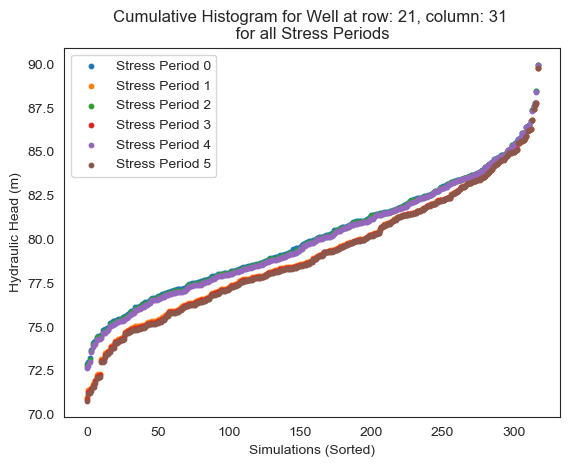

In [434]:
import seaborn as sns

wn = 844
#int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0])
print(wn,int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0]))

wnlist = [wn*numTS + i for i in range(numTS)]
for i in range(numTS):
    #hist = plt.hist(well_head_df[wn*numTS + i], bins = 20,histtype = 'step', cumulative=True, label ='Stress Period '+str(i) )   
   # plt.plot(well_head_df[wn*numTS + i].sorted_values(), bins = 20,histtype = 'step', cumulative=True, label ='Stress Period '+str(i) )   
    plt.scatter(range(len(well_head_df.loc[:,idx[str(wn),i]].index)),well_head_df.loc[:,idx[str(wn),i]].sort_values(), s = 10, label='Stress Period '+str(i))
    #plt.plot(range(well_head_df.shape[0]),np.repeat(well_head_df[wn*numTS + i].mean(),well_head_df.shape[0]),linewidth=1) #plot average as line across simulations

plt.ylabel('Hydraulic Head (m)')
plt.xlabel('Simulations (Sorted)')
plt.title('Cumulative Histogram for Well at row: ' +str(all_well_loc[wn][0])+ ", column: " + str(all_well_loc[wn][1])+ ' \n for all Stress Periods ')
plt.legend()
plt.show()


In [254]:
# mn = "D:/mfoutput/transientDrawdown/ScenarioSfr750SteadyPumpTest_0.nam"

# ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# reach = ztop[25] - 5

# m = flopy.modflow.Modflow.load(mn)

# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)
# xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
# patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')

# linecollection = xsect.plot_grid(color='black', lw=0.5)
# t = ax.set_title('Steady State Model - Row 25 Cross-Section - Hydraulic Heads for All Simulations')
# xlabel = ax.set_xlabel('Length (m)')
# ylabel = ax.set_ylabel('Elevation (m)')

# well_head_onlyRiv = well_head_df[river_well_loc[0]] 

# print(well_head_onlyRiv)

# for i in well_head_onlyRiv.index:#rand_list: #rand_list[:100]:
# #     modelname = "ScenarioSfrWell750Test3_"+str(i)
# #     fname = modws+'/'+modelname+'.hds'
# #     hdobj = flopy.utils.HeadFile(fname)
# #     head = hdobj.get_data()
#     wtup = xsect.plot_surface(well_head_onlyRiv.loc[i], lw=0.5, alpha=0.25)
#   # wtlow = xsect.plot_surface(head[2], lw=0.5, alpha=0.25, color='purple')
# plt.plot(np.arange(0,5000,100),reach,color='green',linestyle='dashed', lw=1.5)
# #plt.legend()


In [435]:
display(well_head_noRiv)

Stp_head_test_df = well_head_noRiv.loc[:,idx[:,1]]
Stp_head_test_df.columns = Stp_head_test_df.columns.droplevel('Stp').astype('str')

display(Stp_head_test_df)

wellnum           0                                                  \
Stp               0           1           2           3           4   
1        100.947212  100.943222  100.939056  100.935188  100.931114   
2         99.750465   99.712372   99.674309   99.636322   99.598457   
3        100.362366  100.353127  100.343575  100.333717  100.323479   
6         97.486771   97.465065   97.439606   97.418259   97.393150   
7        100.579979  100.560577  100.541008  100.521278  100.501411   
..              ...         ...         ...         ...         ...   
742      107.361809  107.360550  107.358917  107.357780  107.356262   
743       93.388260   93.371178   93.332642   93.316154   93.278214   
744       93.971336   93.966354   93.961098   93.955833   93.950363   
748      103.653870  103.654572  103.655258  103.655922  103.656525   
749       98.082314   98.081413   98.080460   98.079529   98.078537   

wellnum                       1                                      ...  \
Stp               5           0           1           2           3  ...   
1        100.927330  100.701523  100.697456  100.693352  100.689392  ...   
2         99.560699   99.503525   99.465179   99.426880   99.388687  ...   
3        100.313087  100.132065  100.122528  100.112663  100.102463  ...   
6         97.372131   97.236900   97.219040   97.190025   97.172516  ...   
7        100.481422  100.332970  100.313255  100.293381  100.273338  ...   
..              ...         ...         ...         ...         ...  ...   
742      107.355202  107.068184  107.066818  107.065308  107.064056  ...   
743       93.262276   93.172318   93.150993   93.116806   93.096085  ...   
744       93.945038   93.774445   93.769455   93.763885   93.758705  ...   
748      103.657120  103.383713  103.384415  103.385078  103.385727  ...   
749       98.077621   97.869987   97.869080   97.868118   97.867180  ...   

wellnum       2010                                        2011             \
Stp              2          3          4          5          0          1   
1        94.918785  94.913712  94.908867  94.903961  94.603149  94.597885   
2        94.133789  94.105339  94.076935  94.048485  93.854149  93.825554   
3        94.597198  94.587219  94.577087  94.566917  94.284721  94.274788   
6        93.040985  93.028786  93.017067  93.004745  92.797356  92.785591   
7        94.676277  94.663857  94.651382  94.638878  94.366570  94.354050   
..             ...        ...        ...        ...        ...        ...   
742      99.819481  99.817291  99.814789  99.812767  99.425453  99.423111   
743      89.623306  89.603996  89.587303  89.567978  89.424553  89.405449   
744      89.369110  89.364891  89.361862  89.357513  89.107132  89.102905   
748      97.242516  97.242462  97.242393  97.242355  96.916084  96.916016   
749      93.123878  93.122223  93.120552  93.118896  92.846779  92.845070   

wellnum                                              
Stp              2          3          4          5  
1        94.592873  94.587761  94.582893  94.577965  
2        93.797020  93.768486  93.739990  93.711479  
3        94.264763  94.254532  94.244232  94.233887  
6        92.774338  92.762405  92.751015  92.738930  
7        94.341507  94.328903  94.316261  94.303574  
..             ...        ...        ...        ...  
742      99.420387  99.418221  99.415680  99.413704  
743      89.389069  89.369919  89.353493  89.334305  
744      89.099937  89.095573  89.092537  89.088066  
748      96.915894  96.915840  96.915733  96.915688  
749      92.843369  92.841682  92.839981  92.838303  

[318 rows x 11646 columns]

wellnum,0,1,2,3,4,5,6,7,8,9,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
1,100.943222,100.697456,100.290398,99.788170,99.193954,98.683769,98.151222,97.609375,97.066040,96.527748,...,99.055138,98.545555,98.013763,97.472794,96.930450,96.393227,95.868912,95.370209,94.923775,94.597885
2,99.712372,99.465179,99.057159,98.555199,97.961235,97.425453,96.876358,96.311188,95.737503,95.162689,...,98.329315,97.813690,97.288193,96.749977,96.206146,95.663689,95.130875,94.621086,94.162216,93.825554
3,100.353127,100.122528,99.741341,99.271919,98.715866,98.198105,97.663437,97.116814,96.564514,96.012802,...,98.739098,98.228630,97.703140,97.167633,96.628075,96.090889,95.563850,95.060127,94.607010,94.274788
6,97.465065,97.219040,96.810799,96.298988,95.673241,95.433403,95.115669,94.762047,94.390785,94.009918,...,96.135185,95.812668,95.439667,95.042854,94.634644,94.221741,93.811028,93.413658,93.052567,92.785591
7,100.560577,100.313255,99.903648,99.398277,98.798828,98.239693,97.669243,97.088028,96.502625,95.919876,...,98.943649,98.403923,97.856544,97.301796,96.745888,96.195297,95.657890,95.146591,94.688637,94.354050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,107.360550,107.066818,106.578384,105.969971,105.246460,104.588593,103.909836,103.224701,102.541954,101.869125,...,104.995346,104.340263,103.664749,102.983162,102.304222,101.635429,100.985886,100.370728,99.822166,99.423111
743,93.371178,93.150993,92.780411,92.314034,91.749451,91.553528,91.285461,90.976280,90.646088,90.306755,...,92.333633,92.059174,91.738281,91.391640,91.032211,90.668198,90.306602,89.957222,89.639954,89.405449
744,93.966354,93.769455,93.444679,93.047432,92.576561,92.191475,91.776367,91.345657,90.907486,90.467979,...,92.671364,92.280380,91.864998,91.437256,91.004219,90.571609,90.146210,89.738869,89.372032,89.102905
748,103.654572,103.384415,102.935379,102.378716,101.719521,101.179070,100.620041,100.055779,99.494011,98.941063,...,101.490143,100.952164,100.396111,99.835220,99.277145,98.728111,98.195580,97.691673,97.242599,96.916016


In [436]:
best_pars_dt = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}

In [458]:
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 100

#new_zone_q = np.log(ReachQdf.loc[well_head_noRiv.index]+1)
#new_zone_q = ReachQdf.loc[well_head_noRiv.index]


rn = 32
#StrPer = [i+1 for i in range(stps, stps+numTS)]
#take the last stress period (-1) - welldf columns are strings 
SingleStpHeads = well_head_noRiv.loc[:,idx[:,['40','41']]]
SingleStpHeads.columns = SingleStpHeads.columns.droplevel('Stp').astype('str') #have to do this for the TreeRegressor to keep the wellnums

#outputs = RevisedOutputdf.loc[idx[:,:,rn]].unstack(level='Stp')
outputs = RevisedOutputdf.loc[idx[StrPer[-2:],:,rn]].unstack(('Stp','reach'))
#display(outputs)

imp_df, metrics_df, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, SingleStpHeads, outputs, best_pars_dt, 0.2, n)  

print('Total time: ' + str(time.time()-t0))

# plt.scatter(y_test, y_pred, label = str("Stress Period " + str(1+i)))

# outmax = np.max(y_pred) +1
# plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

# plt.xlabel("Actual Streamflow")
# plt.ylabel("Predicted Streamflow")
# title = "Example Decision Tree Regression for Q at reach " + str(rn)
# plt.title(title)
# #plt.yscale('log')
# #plt.xscale('log')
# #plt.legend()
# plt.show()

print(metrics_df)
#plt.figure()


Shape of Input Samples: (318, 3882)
Shape of Output Targets: (318, 2)


MemoryError: Unable to allocate 970. MiB for an array with shape (1, 127205376) and data type float64

In [362]:
# #imp_df.to_pickle('Drawdown_DT_Impdf.pkl')
# stp = 0
# plt.figure()
# if numTS != 1:    
#     plt.scatter(y_test[:,stp], y_pred[:,stp])
# else:
#     plt.scatter(y_test[:], y_pred[:])
# #
# outmax = np.max(outputs)
# plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

# plt.xlabel("Actual Streamflow")
# plt.ylabel("Predicted Streamflow")
# title = "Decision Tree Regression for All Reaches for Stress Period " +str(stp) + "\n Median NSE: " +str(round(np.median(NSEList),2)) #Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
# plt.title(title)
# #plt.yscale('log')
# #plt.xscale('log')
# #plt.legend()
# plt.show()

## Tree using Wells to predict Qout

C:\Users\davem\AppData\Local\Temp\ipykernel_18204\1819652875.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


Text(0.5, 1.0, 'Importance values for each cell in predicting flow at reach 32')

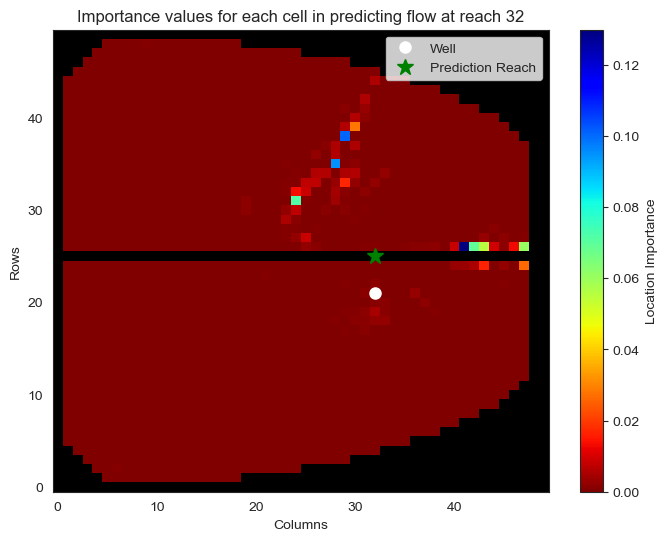

In [455]:
# import importlib
# import treeFuncs
# importlib.reload(treeFuncs)
# from treeFuncs import plotImportance

# numTS = 1
# n = 100

# title = '100 Decision Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

# wellmesh_df = plotImportance(imp_df,well_head_noRiv, well_loc_df,numTS,n,rn,title)
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid
#display(imp_df)
dt_total_imp_df = imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
#Sum up all the stress periods for each well location
#dt_AllTSimp = dt_total_imp_df.groupby(int(dt_total_imp_df.index.values) // numTS).sum()
dt_AllTSimp = dt_total_imp_df
#get indicies of every feature per TS (stressperiod)
# TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

# for i in range(numTS):
#     featInTS = np.intersect1d(dt_total_imp_df.index, TSIndices+i)
#     print(featInTS)
#     print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
#     print("Sum of Importances in Stress period " + str(i) + ": " + str(dt_total_imp_df.loc[featInTS].sum()))
    
#Should probably use this now - it tracks the well location number with the index
#well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])


#feature importance Mapping
wellmesh_dt = np.ndarray((50,50))
wellmesh_dt[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in dt_AllTSimp.index:
        wellmesh_dt[int(well_loc_df.loc[int(k), 1]), int(well_loc_df.loc[int(k), 0])] = dt_AllTSimp.loc[k]

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(dt_AllTSimp)
#vmax = 0.1
vmin = np.min(dt_AllTSimp)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_dt,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.legend()
plt.title('Importance values for each cell in predicting flow at reach ' + str(rn))


In [62]:
wellmesh_AllTs = np.ndarray((numTS,50,50))
wellmesh_AllTs[:,:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs, axis = 0)
#for i in range(all_well_loc.shape[0]):

#featInTS = np.intersect1d(usedFeatures, featIndices)
#pd.DataFrame(importanceArr[featInTS])#just going to use step period 0
for i in range(numTS):
    featInTS = np.intersect1d(dt_total_imp_df.index, TSIndices+i)    
    for k in featInTS:
        wellnum = k // numTS
        wellmesh_AllTs[i,int(well_loc_df.loc[wellnum, 1]), int(well_loc_df.loc[wellnum, 0])] = dt_total_imp_df.loc[k] #np.sum(importanceList[:,i]) 
    

C:\Users\davem\AppData\Local\Temp\ipykernel_15796\3132623273.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


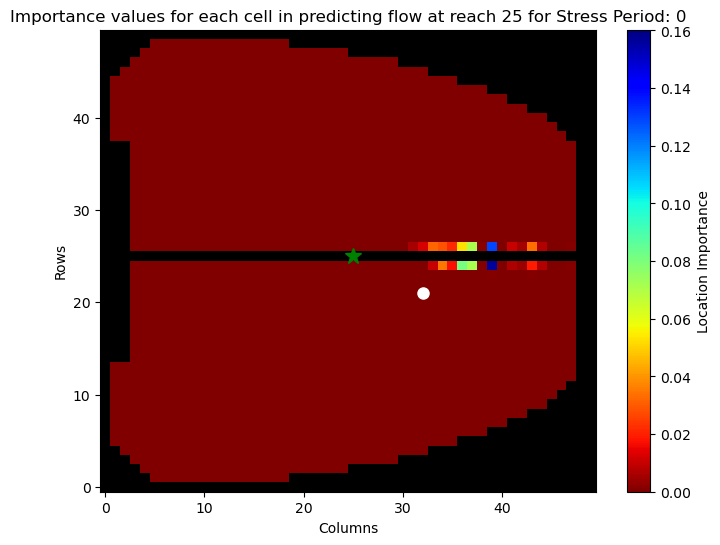

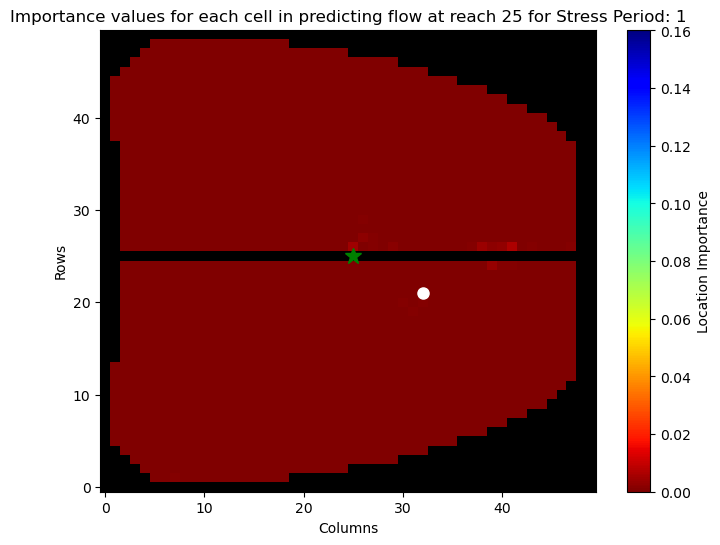

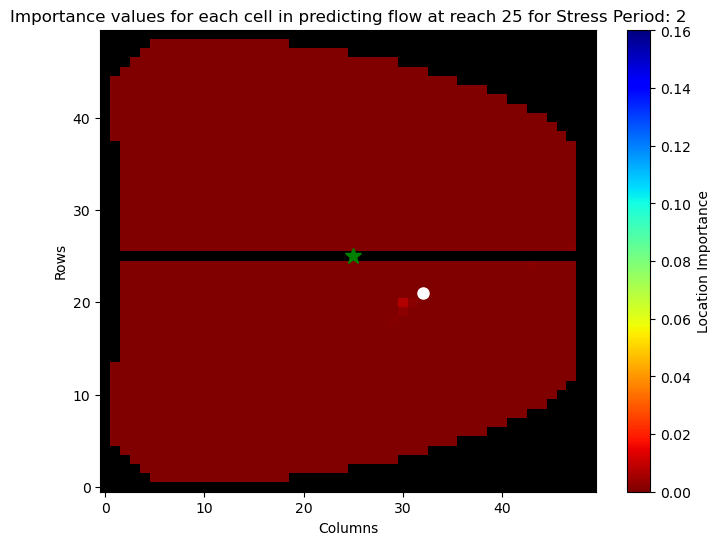

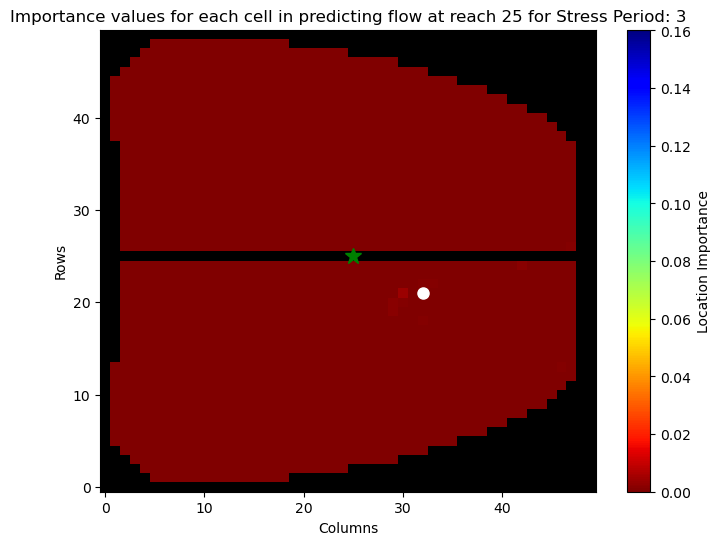

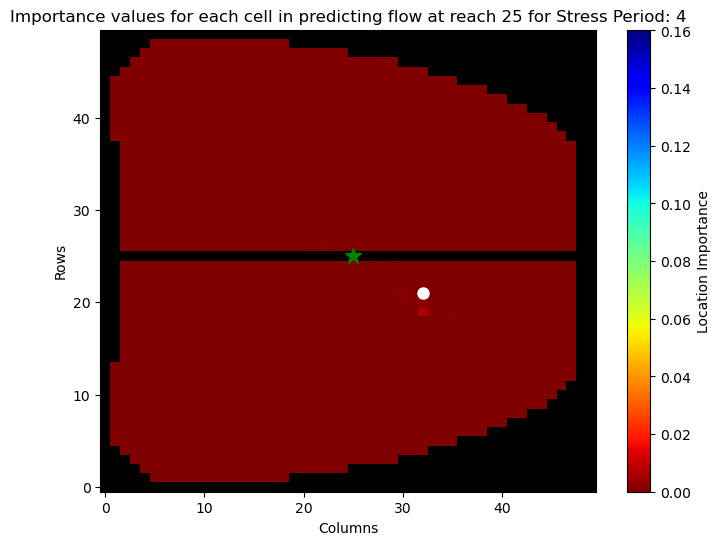

In [64]:
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(dt_AllTSimp)
#vmax = 1
vmin = np.min(dt_AllTSimp)

for i in range(numTS):
    plt.figure(figsize=(8,6))
    plt.pcolormesh(KK,GG,wellmesh_AllTs[i],vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
    plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
    plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
    # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
    #plt.show()
    #plt.imshow(wellmesh, cmap='RdBu')
    plt.colorbar(label = "Location Importance")
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Importance values for each cell in predicting flow at reach ' + str(rn)+' for Stress Period: ' +str(i))


In [29]:
# mostImportant = importance_df.sort_values(ascending=False)[:10]
# print(len(mostImportant.index))

# AllStrPerMI = mostImportant.index*numTS #for transient
# print(AllStrPerMI)
# first = AllStrPerMI
# for i in range(1,numTS+1):
#     AllStrPerMI = np.append(AllStrPerMI,(first+(i)))#add the location of the ather stress period heads
# #temp = [k for i in mostImportant.index for k in np.arange(i,i+numTS).tolist()] #very proud of this double list comprehension - expand it back out to include the all the time series
# print(mostImportant)
# print(AllStrPerMI)

10
Int64Index([4775, 4770, 4570, 4795, 4545, 4800, 4550, 4785, 4805, 4780], dtype='int64')
955    21.472034
954    19.032898
914     8.463551
959     8.338831
909     8.198339
960     4.472221
910     2.612243
957     2.344717
961     2.291125
956     2.026739
dtype: float64
[4775 4770 4570 4795 4545 4800 4550 4785 4805 4780 4776 4771 4571 4796
 4546 4801 4551 4786 4806 4781 4777 4772 4572 4797 4547 4802 4552 4787
 4807 4782 4778 4773 4573 4798 4548 4803 4553 4788 4808 4783 4779 4774
 4574 4799 4549 4804 4554 4789 4809 4784 4780 4775 4575 4800 4550 4805
 4555 4790 4810 4785]


In [30]:
# # Split dataset into training set and test set, default here is 30% test
# t0 = time.time()
# n = 100

# PredList = []
# NSEList = []
# miimportanceList = []
# miimportanceListAll = []

# #new_zone_q = ReachQdf.loc[well_head_noRiv.index]
# mostImpWellHead = well_head_df.loc[:,AllStrPerMI]
# print(mostImpWellHead)
# for i in range(n):
#     well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
#     X_train, X_test, y_train, y_test = train_test_split(mostImpWellHead,outputs, test_size=0.3, random_state=0)
#     # Create Random Forest Object
#     Tree = DecisionTreeRegressor(
#     #max_depth = 2 {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
#     )

#     # Train Decision Tree Classifer
#     Tree = Tree.fit(X_train,y_train)

#     #Predict the response for test dataset
#     y_pred = Tree.predict(X_test)
#     PredList.append(y_pred)
#     NSEList.append(NSE(y_pred, y_test))
#     #feature importance
#     #importanceList.append(Tree.feature_importances_)
#     implist = Tree.feature_importances_
#     temp = [sum(implist[i:i+numTS]) for i in range(0, len(implist), numTS)]
#     miimportanceList.append(temp)
#     miimportanceListAll.append(implist)
    
    
# #well head Tree NSE
  
# #print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
# print("Average NSE: ", np.mean(NSEList))

# t1 = time.time()

# total = t1-t0
# print('Total time: ' + str(total))

          4775       4770        4570        4795       4545        4800  \
0    68.906067  70.384895   98.492851   98.871437  64.555237   98.739357   
1    66.515030  67.913025  100.559120  101.137085  63.554932  101.004166   
2    66.254593  67.554787   98.635185   99.183830  63.479275   99.052681   
3    65.030655  65.967842   88.747360   89.174500  63.063000   89.077927   
4    67.952934  69.459412   97.947357   98.457420  64.196793   98.331024   
..         ...        ...         ...         ...        ...         ...   
590  66.249870  67.483147   94.011108   94.498497  63.517853   94.386711   
591  65.687469  66.757629   87.969978   88.379448  63.331066   88.286964   
592  67.075920  68.657974   96.934311   97.225983  63.728870   97.128868   
593  72.037987  73.726120   99.789101   99.486328  65.917389   99.477203   
594  67.185913  68.589378   97.321396   97.850594  63.906578   97.726532   

           4550       4785        4805       4780  ...       4780       4775  \
0     9

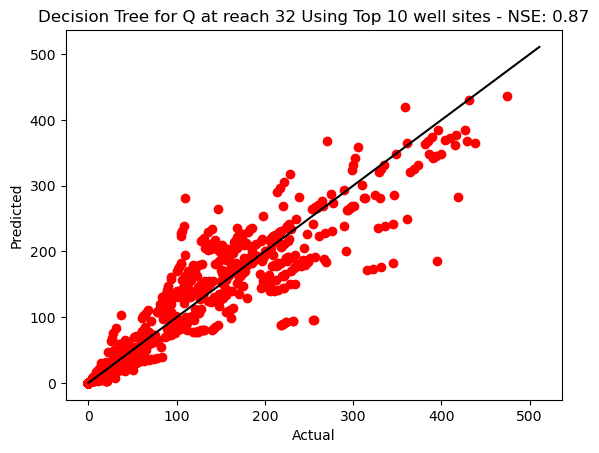

0     15.447049
1      1.772444
2     54.107759
3      1.724856
4      3.264781
5      1.847399
6      5.998658
7      2.547143
8      5.164599
9      2.143887
10     3.665208
11     2.316217
dtype: float64


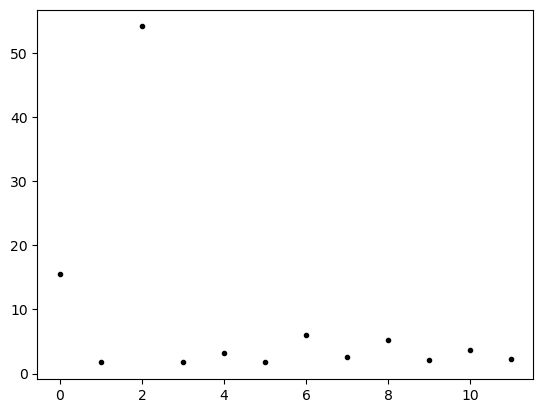

In [32]:
# #print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))
# plt.figure()
# plt.scatter(y_test, y_pred, color='r')
# outmax = np.max(test_q)
# plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# title = "Decision Tree for Q at reach " + str(rn) +" Using Top 10 well sites - NSE: " + str(round(NSEList[-1],2))
# plt.title(title)
# #plt.yscale('log')
# #plt.xscale('log')
# #plt.legend()
# plt.show()


# #WellStreamimportance = Tree.feature_importances_
# #print(WellStreamimportance)
# miimportance_df = pd.DataFrame(miimportanceList).sum()
# #miimportance_df['wellnum'] = mostImpWellHead.columns
# print(miimportance_df)
# plt.plot(miimportance_df, '.k')

In [33]:
# feature importance Mapping
# miwellmesh = np.ndarray((50,50))
# miwellmesh[:,:] = -1e30
# #all_well_locNoRiv = np.delete(all_well_loc, river_well_loc[0], axis = 0)
# #for i in range(all_well_loc.shape[0]):
# for i,k in enumerate(mostImportant.index):
#     #if(all_well_loc[i,1] != 25):
#     miwellmesh[int(all_well_locNoRiv[k, 1]), int(all_well_locNoRiv[k, 0])] = miimportance_df[i] #np.sum(importanceList[:,i])  


C:\Users\davem\AppData\Local\Temp\ipykernel_6300\3615926601.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


Text(0.5, 1.0, 'Importance values')

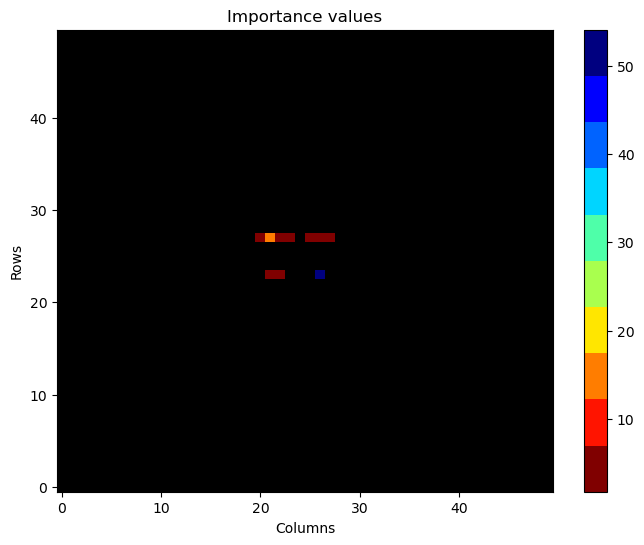

In [34]:
# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# #PLotting out the result grid

# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(miimportance_df)
# #vmax = 1
# vmin = np.min(miimportance_df)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,miwellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Importance values')


In [ ]:

# result = permutation_importance(
#     Tree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )
# print(result.importances_mean)

# wellmesh = np.ndarray((50,50))
# wellmesh[:,:] = -1e30

# for i in range(all_well_loc.shape[0]):
#     wellmesh[int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = result.importances_mean[i] #np.sum(importanceList[:,i])

# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(0.001)
# vmin = np.min(WellStreamimportance)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Permutation Importance values')

## Gradient Boosting

In [18]:
#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

print(GradientBoostingRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
#rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
rn = 25
outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this

#print(rand_well)
#Randomized cv search only works with a single output when using gradient boosting regressor, apparently, so using the last stress period data
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs[:,-1], test_size=0.2) 
#X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[32], test_size=0.2)
loss = ['squared_error', 'absolute_error', 'huber', 'quantile']
n_estimators = [int(x) for x in range(25,275,50)]
subsample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
splitter = ['best']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'loss' : loss,
                'subsample':subsample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgr_random = RandomizedSearchCV(estimator = xgr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgr_random.fit(X_train, y_train)# error_score='raise')
best_pars_gr = xgr_random.best_params_
print(best_pars_gr)

#from sklearn.tree import plot_tree


best_random_gr = xgr_random.best_estimator_
y_pred = best_random_gr.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
{'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10, 25], 'min_samples_leaf': [1, 2, 4], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.5, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrea

NameError: name 'best_random' is not defined

In [75]:
best_pars_gr = {'subsample': 0.5, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'huber', 'criterion': 'friedman_mse'}

In [79]:
#Gradient Boosting-  Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
importanceList = []
importanceListAll = []

depthlist = []

gr_imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn = 25

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs[:,-1], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object
    xgBest = GradientBoostingRegressor(**best_pars_gr)
   # Train Decision Tree Classifer
    xgBest.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = xgBest.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    #depthlist.append(xgBest.get_depth())
    #feature importance
    gr_feat_df = pd.DataFrame(xgBest.feature_importances_, index = xgBest.feature_names_in_.astype('int')) 
    gr_imp_df = gr_imp_df.merge(gr_feat_df.rename(columns={0:i}), left_index=True, right_index = True)
    
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.mean(NSEList))
#print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))



Average NSE:  0.9709940471736795
Total time: 9.53002142906189


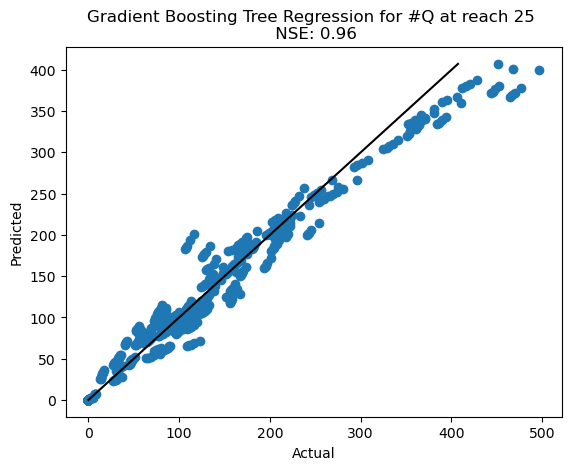

In [107]:
gr_imp_df.to_pickle('Drawdown_GB_Impdf.pkl')


plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Gradient Boosting Tree Regression for #Q at reach " + str(rn) +" \n NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

0.9999999999999999
[    0     5    10 ... 10045 10050 10055]
Number of Features used in Stress period 0: 1895
Sum of Importances in Stress period 0: 0.37857834678340563
[    1     6    11 ... 10046 10051 10056]
Number of Features used in Stress period 1: 1918
Sum of Importances in Stress period 1: 0.36082972642600386
[    2     7    12 ... 10047 10052 10057]
Number of Features used in Stress period 2: 1918
Sum of Importances in Stress period 2: 0.14638335448450523
[    3     8    13 ... 10048 10053 10058]
Number of Features used in Stress period 3: 1918
Sum of Importances in Stress period 3: 0.05521919486821175
[    4     9    14 ... 10049 10054 10059]
Number of Features used in Stress period 4: 1918
Sum of Importances in Stress period 4: 0.05898937743787351


C:\Users\davem\AppData\Local\Temp\ipykernel_15796\1692959661.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


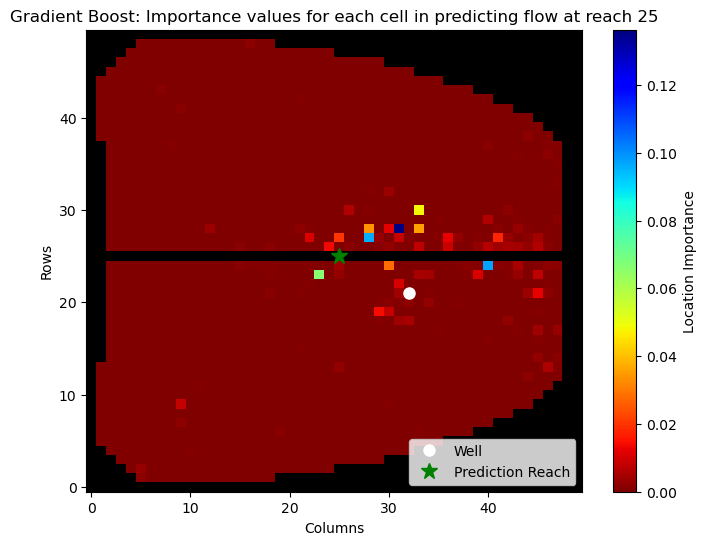

In [94]:
gr_total_imp_df = gr_imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
print(gr_total_imp_df.sum())
#Sum up all the stress periods for each well location
gr_AllTSimp = gr_total_imp_df.groupby(gr_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

for i in range(numTS):
    featInTS = np.intersect1d(gr_total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(gr_total_imp_df.loc[featInTS].sum()))
    
#Should probably use this now - it tracks the well location number with the index
#well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])


#feature importance Mapping
wellmesh_gr = np.ndarray((50,50))
wellmesh_gr[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in gr_AllTSimp.index:
        wellmesh_gr[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = gr_AllTSimp.loc[k]
# for i in range(len(importance_df.index)):

#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(gr_AllTSimp)
#vmax = 0.1
vmin = np.min(gr_AllTSimp)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_gr,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Gradient Boost: Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")

## Random Forest - Transient Drawdown Scenario

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
RMSE:  24.772046629417623


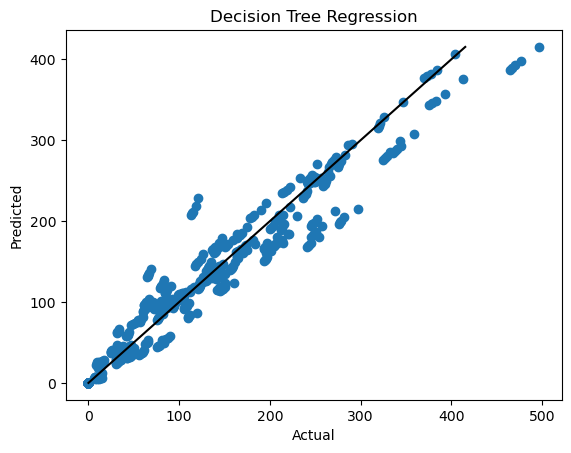

In [40]:
from sklearn.ensemble import RandomForestRegressor
#rn = 25

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

print(RandomForestRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2)
n_estimators = [int(x) for x in range(25,275,50)]
max_sample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
#splitter = ['best']
bootstrap = ['True']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
#max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                #'bootstrap' : bootstrap,
                'max_samples':max_sample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rfr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rfr_random.fit(X_train, y_train)
best_pars_rf = rfr_random.best_params_
print(best_pars_rf)

#from sklearn.tree import plot_tree


best_random_rf = rfr_random.best_estimator_
y_pred = best_random_rf.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

In [83]:
best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}

In [98]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
importanceList_rf = []
importanceListAll_rf = []
depthlist = []

rf_imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

rn = 25

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
 
    RF = RandomForestRegressor(**best_pars_rf)
    
    RF = RF.fit(X_train,y_train)
    y_pred = RF.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))

    rf_feat_df = pd.DataFrame(RF.feature_importances_, index = RF.feature_names_in_.astype('int')) 
    rf_imp_df = rf_imp_df.merge(rf_feat_df.rename(columns={0:i}), left_index=True, right_index = True)
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.nanmean(NSEList))
#print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))


Average NSE:  0.9619705834847866
Total time: 736.5224423408508


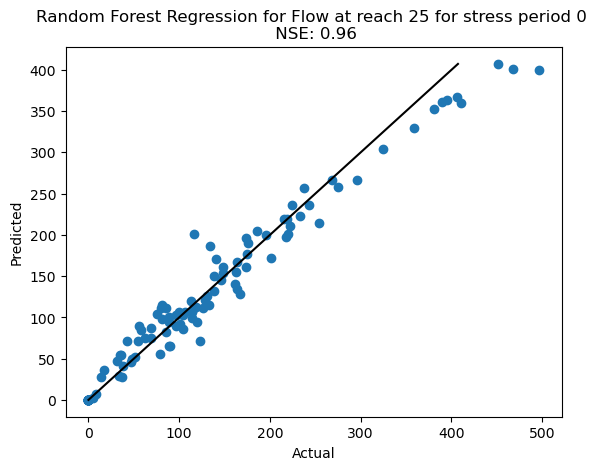

In [105]:
rf_imp_df.to_pickle('Drawdown_RF_Impdf.pkl')


stp = 0
plt.figure()
plt.scatter(y_test[:,stp], y_pred[:,stp])
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Random Forest Regression for Flow at reach " + str(rn) +" for stress period " + str(stp) + " \n NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

1.0
[    0     5    10 ... 10045 10050 10055]
Number of Features used in Stress period 0: 1895
Sum of Importances in Stress period 0: 0.823348439733127
[    1     6    11 ... 10046 10051 10056]
Number of Features used in Stress period 1: 1918
Sum of Importances in Stress period 1: 0.06946328788040948
[    2     7    12 ... 10047 10052 10057]
Number of Features used in Stress period 2: 1918
Sum of Importances in Stress period 2: 0.033731303153823874
[    3     8    13 ... 10048 10053 10058]
Number of Features used in Stress period 3: 1918
Sum of Importances in Stress period 3: 0.031061114775394506
[    4     9    14 ... 10049 10054 10059]
Number of Features used in Stress period 4: 1918
Sum of Importances in Stress period 4: 0.04239585445724538


C:\Users\davem\AppData\Local\Temp\ipykernel_15796\4001706885.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


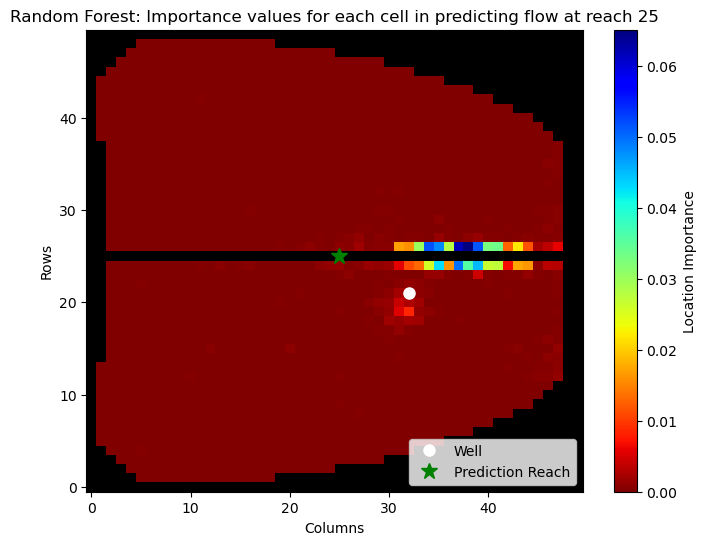

In [95]:
rf_total_imp_df = rf_imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
print(rf_total_imp_df.sum())
#Sum up all the stress periods for each well location
rf_AllTSimp = rf_total_imp_df.groupby(rf_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

for i in range(numTS):
    featInTS = np.intersect1d(rf_total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(rf_total_imp_df.loc[featInTS].sum()))
    
#feature importance Mapping
wellmesh_rf = np.ndarray((50,50))
wellmesh_rf[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in rf_AllTSimp.index:
        wellmesh_rf[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = rf_AllTSimp.loc[k]


cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(rf_AllTSimp)
#vmax = 0.1
vmin = np.min(rf_AllTSimp)
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_rf,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Random Forest: Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")


[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.96419839 0.98651288 0.95561707 1.        ]
 [0.95976932 0.98479047 0.95044983 1.        ]
 ...
 [0.03137255 0.2044752  0.44372165 1.        ]
 [0.03137255 0.19635525 0.43166474 1.        ]
 [0.03137255 0.18823529 0.41960784 1.        ]]


C:\Users\davem\AppData\Local\Temp\ipykernel_15796\498297761.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)


[Text(0.0, 0, ''),
 Text(0.15, 0, 'Random Forest'),
 Text(0.5, 0, 'Gradient Boosted'),
 Text(0.85, 0, 'Decision Tree'),
 Text(1.0, 0, '')]

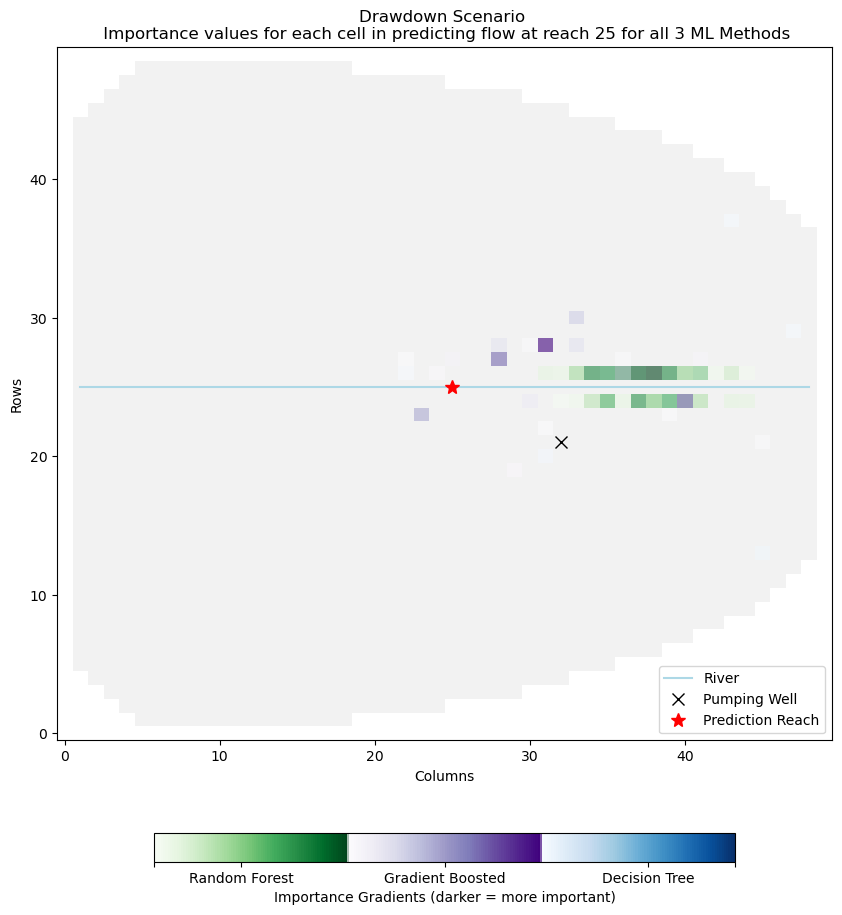

In [101]:
river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.01)
vmaxrf = np.max(wellmesh_rf)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_gr, wellmesh_gr < 0.01)
vmaxgr = np.max(wellmesh_gr)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_dt, wellmesh_dt < 0.01)
vmaxdt = np.max(wellmesh_dt)

vmin = 0.01
# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128))))
print(colors)

mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = vmax, vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmaxdt, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmaxrf, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmaxgr, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Drawdown Scenario \n Importance values for each cell in predicting flow at reach ' + str(rn) + ' for all 3 ML Methods')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.15,0.5,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Random Forest', 'Gradient Boosted','Decision Tree',''])
#plt.legend()